In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

In [2]:
df=pd.read_csv("netflixData.csv")

In [3]:
df.head()

,Show Id,Title,Description,Director,Genres,Cast,Production Country,Release Date,Rating,Duration,Imdb Score,Content Type,Date Added
0,cc1b6ed9-cf9e-4057-8303-34577fb54477,(Un)Well,This docuseries takes a deep dive into the luc...,NaN,Reality TV,NaN,United States,2020.0,TV-MA,1 Season,6.6/10,TV Show,NaN
1,e2ef4e91-fb25-42ab-b485-be8e3b23dedb,#Alive,"As a grisly virus rampages a city, a lone man ...",Cho Il,"Horror Movies, International Movies, Thrillers","Yoo Ah-in, Park Shin-hye",South Korea,2020.0,TV-MA,99 min,6.2/10,Movie,"September 8, 2020"
2,b01b73b7-81f6-47a7-86d8-acb63080d525,#AnneFrank - Parallel Stories,"Through her diary, Anne Frank's story is retol...","Sabina Fedeli, Anna Migotto","Documentaries, International Movies","Helen Mirren, Gengher Gatti",Italy,2019.0,TV-14,95 min,6.4/10,Movie,"July 1, 2020"
3,b6611af0-f53c-4a08-9ffa-9716dc57eb9c,#blackAF,Kenya Barris and his family navigate relations...,NaN,TV Comedies,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,2020.0,TV-MA,1 Season,6.6/10,TV Show,NaN
4,7f2d4170-bab8-4d75-adc2-197f7124c070,#cats_the_mewvie,This pawesome documentary explores how our fel...,Michael Margolis,"Documentaries, International Movies",NaN,Canada,2020.0,TV-14,90 min,5.1/10,Movie,"February 5, 2020"


In [4]:
df.isnull().sum()

Show Id                  0
Title                    0
Description              0
Director              2064
Genres                   0
Cast                   530
Production Country     559
Release Date             3
Rating                   4
Duration                 3
Imdb Score             608
Content Type             0
Date Added            1335
dtype: int64

In [5]:
df.shape

(5967, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5967 entries, 0 to 5966
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Show Id             5967 non-null   object 
 1   Title               5967 non-null   object 
 2   Description         5967 non-null   object 
 3   Director            3903 non-null   object 
 4   Genres              5967 non-null   object 
 5   Cast                5437 non-null   object 
 6   Production Country  5408 non-null   object 
 7   Release Date        5964 non-null   float64
 8   Rating              5963 non-null   object 
 9   Duration            5964 non-null   object 
 10  Imdb Score          5359 non-null   object 
 11  Content Type        5967 non-null   object 
 12  Date Added          4632 non-null   object 
dtypes: float64(1), object(12)
memory usage: 606.1+ KB


In [7]:
df.columns

Index(['Show Id', 'Title', 'Description', 'Director', 'Genres', 'Cast',
       'Production Country', 'Release Date', 'Rating', 'Duration',
       'Imdb Score', 'Content Type', 'Date Added'],
      dtype='object')

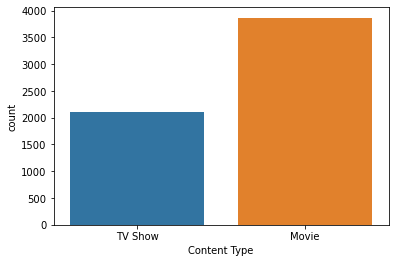

In [8]:
sns.countplot(x=df['Content Type']);

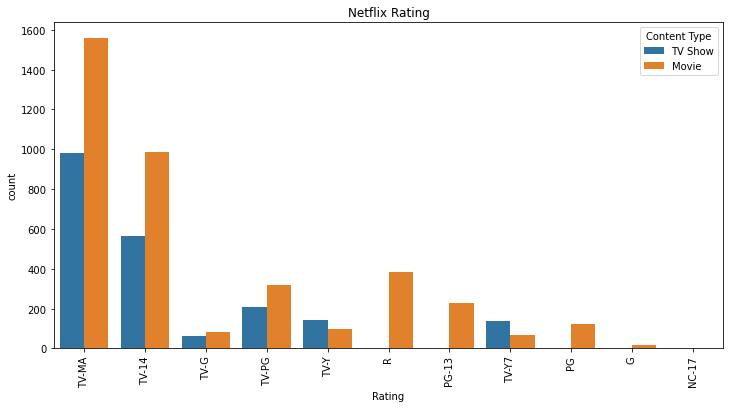

In [9]:
plt.figure(figsize=(12,6))
plt.title("Netflix Rating")
sns.countplot(x=df["Rating"],hue=df["Content Type"]);
plt.xticks(rotation=90);

In [10]:
df= df.dropna()

#Bazı veri hazırlıkları içerdiğinden Başlık sütununu temizleyeceğiz.

In [11]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Berkay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["Title"] = df["Title"].apply(clean)

In [13]:
df.Title.sample(10)

3574              soul night
4536     take ball pass ball
1155                cut bank
1157                    cuti
1014             cinar agaci
4552                   tango
2992       mari witch flower
5634                    uyar
475                    ayana
5065    assassin woman world
Name: Title, dtype: object

In [14]:
df.Title.sample(10)

3381                              nese hayat
3945              richard pryor live concert
3845                                rais bar
2841                                 lovecom
249                  ala vaikunthapurramuloo
5920                                    high
1522    eurovis song contest stori fire saga
590                      elmo puppet journey
233                               air strike
1812                              gim record
Name: Title, dtype: object

#İçerikleri önerme özelliği olarak Türler sütununu kullanacağım. Burada kosinüs benzerliği kavramını kullanacağım. (iki belgedeki benzerlikleri bulmak için kullanılır)

In [15]:
feature = df["Genres"].tolist()
tfidf = text.TfidfVectorizer(input=feature, stop_words="english")
tfidf_matrix = tfidf.fit_transform(feature)
similarity = cosine_similarity(tfidf_matrix)

#Filmin veya TV dizisinin adını girdi olarak vererek benzer içerikleri bulabiliriz:

In [16]:
indices = pd.Series(df.index, 
                    index=df['Title']).drop_duplicates()

In [17]:
def netFlix_recommendation(title, similarity = similarity):
    index = indices[title]
    similarity_scores = list(enumerate(similarity[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[0:10]
    movieindices = [i[0] for i in similarity_scores]
    return df['Title'].iloc[movieindices]

In [18]:
netFlix_recommendation('mom war')

371       angel  demon
466               awak
630              world
1094           cop car
1183        danger lie
1227        dead illus
1289      deviant love
1348    domest disturb
1366    doubl jeopardi
1581      fatal affair
Name: Title, dtype: object

In [19]:
df=df[["Title", "Description", "Content Type", "Genres", "Release Date", "Rating", "Duration", "Imdb Score"]]

In [20]:
df["Release Date"]=df["Release Date"].fillna("Release Date")

In [21]:
df["Rating"]=df["Rating"].fillna("Rating")

In [22]:
df["Duration"]=df["Duration"].fillna("Duration")

In [23]:
df["Imdb Score"]=df["Imdb Score"].fillna("Imdb Score")

In [24]:
df.isnull().sum()

Title           0
Description     0
Content Type    0
Genres          0
Release Date    0
Rating          0
Duration        0
Imdb Score      0
dtype: int64

In [25]:
x=pd.get_dummies(df,drop_first=True)

In [26]:
model=KMeans(n_clusters=4)

In [27]:
model=model.fit(x)

In [28]:
tahmin=model.predict(x)

In [29]:
tahmin

array([1, 1, 1, ..., 0, 0, 1])

In [30]:
df["cluster"]=tahmin

In [31]:
df.head()

,Title,Description,Content Type,Genres,Release Date,Rating,Duration,Imdb Score,cluster
1,aliv,"As a grisly virus rampages a city, a lone man ...",Movie,"Horror Movies, International Movies, Thrillers",2020.0,TV-MA,99 min,6.2/10,1
2,annefrank parallel stori,"Through her diary, Anne Frank's story is retol...",Movie,"Documentaries, International Movies",2019.0,TV-14,95 min,6.4/10,1
5,friendbutmarri,"Pining for his high school crush for years, a ...",Movie,"Dramas, International Movies, Romantic Movies",2018.0,TV-G,102 min,7.0/10,1
6,friendbutmarri,As Ayu and Ditto finally transition from best ...,Movie,"Dramas, International Movies, Romantic Movies",2020.0,TV-G,104 min,7.0/10,1
7,realityhigh,When nerdy high schooler Dani finally attracts...,Movie,Comedies,2017.0,TV-14,99 min,5.1/10,1


In [32]:
df.shape

(3260, 9)

In [33]:
silhouette_score(x,tahmin)

0.5025886435849299

In [34]:
allscore=[]
allclusters=[]
kırılma=[]
def clust(kactane):
    
    for i in range(1,kactane+1):
        i=i+1
        model=KMeans(n_clusters=i)
        model=model.fit(x)
        tahmin=model.predict(x)
        score=silhouette_score(x,tahmin)
        uzaklik=model.inertia_
        print("Cluster ",i," score ",score)
        allscore.append(score)
        allclusters.append(i)
        kırılma.append(uzaklik)
clust(10)

Cluster  2  score  0.7402166083427056
Cluster  3  score  0.5517413917122821
Cluster  4  score  0.5025886435849299
Cluster  5  score  0.3057103312170745
Cluster  6  score  0.2828453776787568
Cluster  7  score  0.24964802811423117
Cluster  8  score  0.19239220459077885
Cluster  9  score  0.15228828065792832
Cluster  10  score  0.14140983202151744
Cluster  11  score  0.1161249459420613


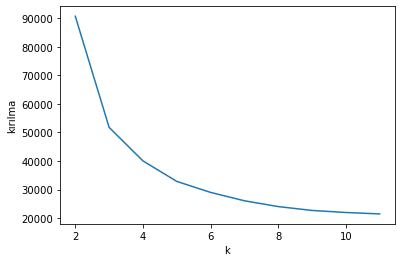

In [35]:
plt.xlabel("k")
plt.ylabel("kırılma")
plt.plot(allclusters,kırılma)

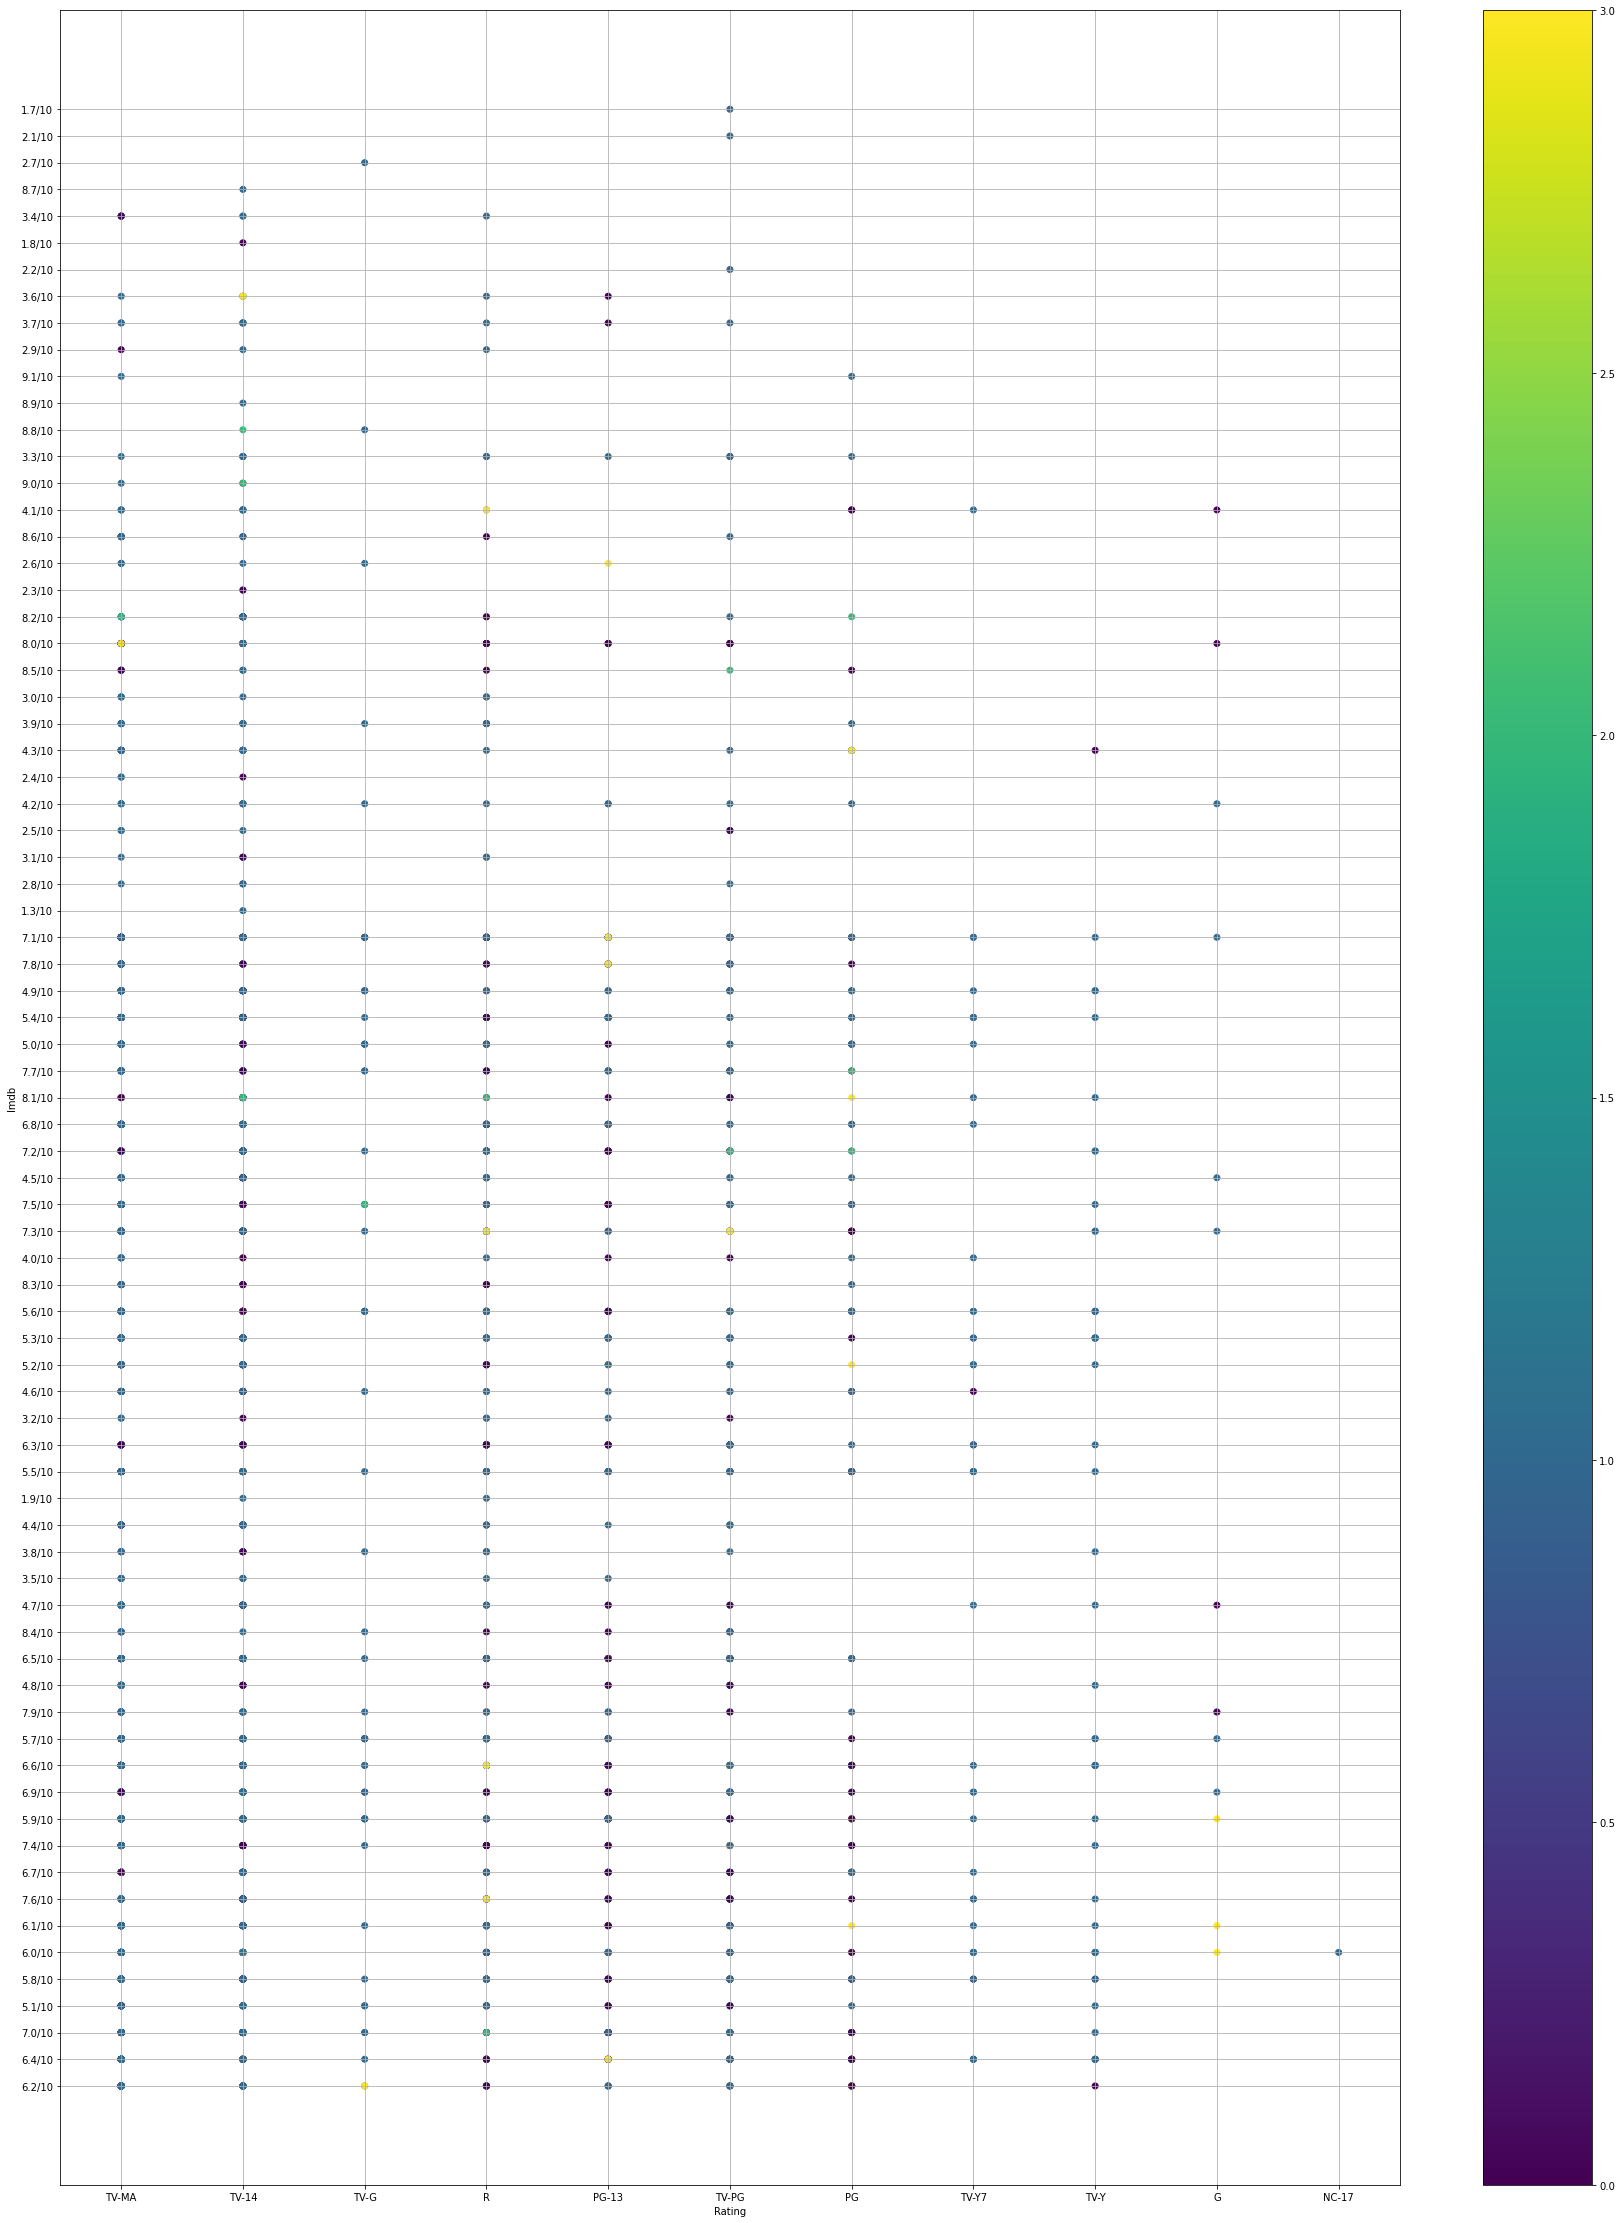

In [43]:
plt.figure(figsize=(30,40))
plt.scatter(df["Rating"],y=df["Imdb Score"],c=tahmin)
plt.xlabel("Rating")
plt.ylabel("Imdb")
plt.colorbar()
plt.grid()